In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
# nltk.download("stopwords")
# nltk.download("punkt")

# Dataset

This project uses data scraped using the *New York Times* API. Due to the API's limitations, the dataset consists of headlines, dates, sections, subjects, and various other metadata but not the articles themselves. The majority of analysis, therefore, will be focused on the headline and abstract text.

In [ ]:
# Load data from GitHub
df = pd.read_csv("https://raw.githubusercontent.com/vyoma-raman/nyt-disability/main/data.csv").fillna("")
# Create columns for year of publication and a concatenation of the headline and abstract
df["year"] = df["date"].apply(lambda d: int(d.split("/")[2]))
df["full_text"] = df.apply(lambda row: " ".join(row[1:3]), axis=1)
# Excluding data on articles published after 2020
df = df[df["year"] <= 2020]
df.tail()

,date,headline,abstract,document_type,type_of_material,news_desk,section_name,subjects,year,full_text
3429,12/22/2020,"Such a Personal, Private Thing': Rethinking th...",The home pregnancy test has long been lauded f...,article,News,Gender,U.S.,"['Pregnancy and Childbirth', 'Tests (Medical)'...",2020,"Such a Personal, Private Thing': Rethinking th..."
3430,12/22/2020,It's What Makes Life Worth Living',The Times's Neediest Cases Fund helped Hope Bu...,article,Editorial,Editorial,Opinion,"['Coronavirus (2019-nCoV)', 'Group Homes and S...",2020,It's What Makes Life Worth Living' The Times's...
3431,12/24/2020,She's a Chess Champion Who Can Barely See the ...,Like the fictional Beth Harmon in “The Queen's...,article,News,Well,Well,"['Lauser, Jessica', 'Chess', 'Blindness', 'Con...",2020,She's a Chess Champion Who Can Barely See the ...
3432,12/27/2020,I Think Beethoven Encoded His Deafness in His ...,"Gabriela Lena Frank, a composer born with high...",article,News,Culture,Arts,"['Deafness', 'Classical Music', 'Disabilities'...",2020,I Think Beethoven Encoded His Deafness in His ...
3433,12/30/2020,Alaska Airlines Clamps Down on Emotional Suppo...,The airline says it will permit service dogs o...,article,News,Express,Business Day,"['Service Dogs and Other Animals', 'Disabiliti...",2020,Alaska Airlines Clamps Down on Emotional Suppo...


In [ ]:
# Split text data into 20-year publication bins
ranges = range(1860, 2001, 20)
data_bins = {}
for r in ranges:
  data = df[(df["year"] > r) & (df["year"] <= r + 20)]
  data_bins["-".join([str(r), str(r + 20)])] = data["full_text"].tolist()

In [ ]:
# Get a list of all text data
all_data = df["full_text"].tolist()

# Content Evolution

This section examines how the *New York Times*' coverage of disability has topically changed over time.

Let's start by looking at word embeddings, which represent the context around which words are used and provide insight into concepts that are related to those words. These embeddings are separately created for different 20-year bins of data. Comparing across bins can illustrate how different ideas are associated with each other in different time intervals.

## Word Embeddings

In [ ]:
# Load English stopwords
stop_words = set(stopwords.words('english'))
# Clean the data for this task
def clean_wv(text):
  text = "".join(ch for ch in text if ch.isalnum() or ch == " ").lower()
  return [w for w in nltk.word_tokenize(text) if not w in stop_words]

In [ ]:
# Create a dictionary of words associated with disability-related words
disability_similar = {}
# Train a new model and collect similar words for each time interval
for r, data in data_bins.items():
  texts_wv = [clean_wv(t) for t in data]
  model = Word2Vec(sentences=texts_wv, size=300, window=5, min_count=1)
  dictionary = {}
  # These words were selected based on how NYTimes categorizes disability-related articles
  for word in ["disabilities", "blindness", "deafness", "amputee"]:
    try:
      similar_words = [w[0] for w in model.wv.most_similar(positive=[word], topn=10)]
    except:
      similar_words = []
    dictionary[word] = similar_words
  disability_similar[r] = dictionary

In [ ]:
# Print the words most similar to the 4 terms of interest
for bin in disability_similar:
  print(bin)
  for word in disability_similar[bin]:
    print("    ", word)
    print("        ", disability_similar[bin][word])

1860-1880
     disabilities
         ['per', 'case', 'royal', 'pierces', 'rigid', 'russells', 'policy', 'dull', '8', 'jeffriess']
     blindness
         ['gleanings', 'family', 'eyes', 'lowell', 'becks', 'yesterday', 'life', 'elephant', 'republicans', 'road']
     deafness
         ['8', 'examinations', 'tinkering', 'compensations', 'pierces', 'gleanings', 'mr', 'printing', 'foreign', 'anthonys']
     amputee
         []
1880-1900
     disabilities
         []
     blindness
         ['tests', 'persons', 'quakers', 'remedy', 'coached', 'pilot', 'protest', 'reading', 'educational', 'commission']
     deafness
         ['central', 'examinations', 'paper', 'royal', 'dr', 'philadelphia', 'results', 'national', 'invention', 'addresses']
     amputee
         []
1900-1920
     disabilities
         []
     blindness
         ['entitled', 'father', 'exhibited', 'children', 'estranged', 'classics', 'scenes', 'watches', 'belasco', 'instrument']
     deafness
         ['jewish', 'gathering', 'b

The similarities found by Word2Vec word embeddings highlight a number of patterns in the kinds of topics disability has been historically associated with in the New York Times. In the 1860-1880 bin, disability words are associated with "policy" and "republicans," suggesting that disability is seen as a phenomenon that can be addressed through legislation. In contrast, the 1880-1900 bin finds intervention-related words such as "dr" (Dr.), "tests," "remedy," and "invention" (potentially implying a link to Alexander Graham Bell, an inventor and teacher of Dead and hard-of-hearing students who lived during that time). Interestingly, most disability words were not found in the 1940-1960 bin, with the exception of "amputee" -- this is potentially due to disability-related coverage being focused on war veterans. Starting in the 1960s, the term "disabilities"" began to be found more. Beginning in the 1980s, it became more closely associated with children and schools, suggesting a shift in journalistic interest or national focus. Around the same time, the four terms investigated ("disabilities," "deafness," "blindness," and "amputee") began to show more similarity with each other. These factors indicate that journalists have started reporting on disability more cohesively.

## Topic Modeling

In [ ]:
# Clean the data for this task
def clean_tm(text):
  return "".join(ch for ch in text if ch.isalnum() or ch == " ").lower()

In [ ]:
# Process data through cleaning and vectorization
texts_tm = [clean_tm(t) for t in all_data]
count_vectorizer = CountVectorizer(stop_words='english', max_features=1000, min_df=0.05, max_df=0.9)
vectorized = count_vectorizer.fit_transform(texts_tm)

In [ ]:
# Perform LDA analysis
num_topics = 4
lda = LatentDirichletAllocation(n_components=num_topics)
lda_topics = lda.fit_transform(vectorized)


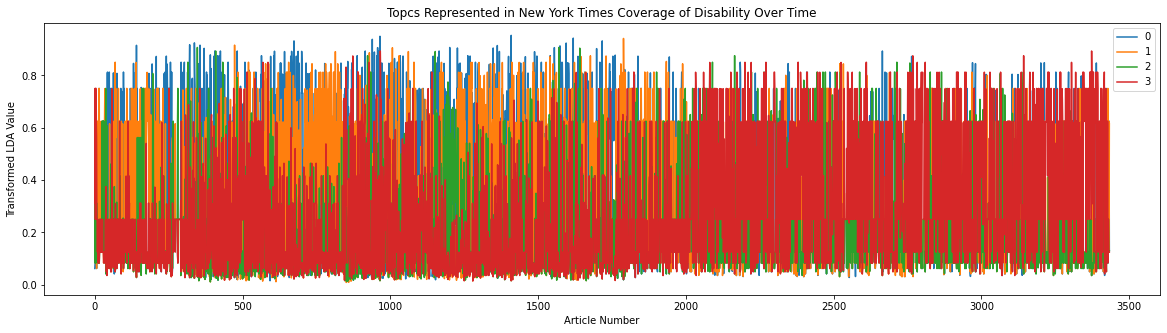

In [ ]:
# Plot the occurrence of topics across the corpus
pd.DataFrame(lda_topics).plot(figsize=(20, 5))
plt.title("Topcs Represented in New York Times Coverage of Disability Over Time")
plt.xlabel("Article Number")
plt.ylabel("Transformed LDA Value")
plt.legend();

In [ ]:
# To contextualize the x-axis, 2000 = March 6, 2011
df.iloc[2000, 0]

'3/6/2011'

In [ ]:
# Print the top 5 words associated with each topic
topic_words = pd.DataFrame(lda.components_, columns=count_vectorizer.get_feature_names())
for i in range(num_topics):
  print("Topic " + str(i) + ": " + " ".join(topic_words.loc[i].sort_values(ascending=False).head(5).index.tolist()))

Topic 0: deaf hearing school students language
Topic 1: blind blindness help lead says
Topic 2: new york city says photo
Topic 3: people disabled disabilities said years


The four topics found using Latent Dirichlet Allocation appear to be as follows:
0. Schools and deafness
1. Blindness
2. The city
3. People with disabilities more generally

As noted in the word similarity analysis, it is visually apparent that dialogue has shifted from blindness and deafness to become more encompassing of disability as a whole. The topic breakdown also suggests that there is a focus on young people with disabilities and people in the city.

## Subject Labeling

Rather than examine the text itself, the graph below visualizes how the *New York Times* has self-labeled the subjects of its articles.

The articles in this dataset were selected by filtering all articles by five subject keywords ("Disabilities," "Blindness," "Deafness," "Prostheses," and "Amputation") that comprise the "Disability" topic on their website. The volume of these keywords over time has been graphed here.

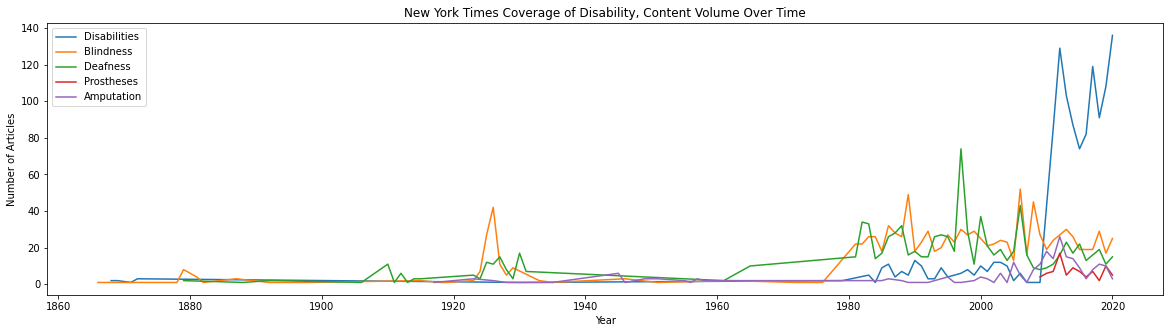

In [ ]:
# Plot change in NYTimes article subject labels over time
plt.figure(figsize=(20, 5))
pd.to_datetime(df[df["subjects"].apply(lambda s: "Disabilities" in s)]["date"]).apply(lambda d: d.year).value_counts().sort_index().plot(label="Disabilities")
pd.to_datetime(df[df["subjects"].apply(lambda s: "Blindness" in s)]["date"]).apply(lambda d: d.year).value_counts().sort_index().plot(label="Blindness")
pd.to_datetime(df[df["subjects"].apply(lambda s: "Deafness" in s)]["date"]).apply(lambda d: d.year).value_counts().sort_index().plot(label="Deafness")
pd.to_datetime(df[df["subjects"].apply(lambda s: "Prostheses" in s)]["date"]).apply(lambda d: d.year).value_counts().sort_index().plot(label="Prostheses")
pd.to_datetime(df[df["subjects"].apply(lambda s: "AMPUTATION" in s)]["date"]).apply(lambda d: d.year).value_counts().sort_index().plot(label="Amputation")
plt.title("New York Times Coverage of Disability, Content Volume Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.legend();

A few notable patterns are apparent: Volume of coverage appears to increase significantly around 1980, though it is unclear whether this is due to archiving. In this peak, however, "Blindness" and "Deafness appear to be the most popular tags (as they are historically) until around 2010, when general disability coverage shoots up and those plateau. Finally, "Prostheses" becomes a tag around 2010.

Interestingly, there is a spike in coverage of articles related to blindness in the mid-1920s. A manual revision of the articles from this time period confirms this finding but fails to pinpoint an event or other reason for this change.

# Lexical Evolution

In the analysis of content in disability-related articles, a recurring theme has been the change in usage of different words. Let's take a look at word usage and variation more specifically.

## Type-Token Ratios

In [ ]:
# Clean the data for this task
def clean_ttr(text):
  text = "".join(ch for ch in text if ch.isalnum() or ch == " ").lower()
  return [w for w in nltk.word_tokenize(text) if not w in stop_words]

In [ ]:
df_ttr = df[["date", "full_text"]].copy()
df_ttr["cleaned"] = df_ttr["full_text"].apply(clean_ttr)

In [ ]:
# Evaluate the type-token ratio of the articles over time
def type_token_ratio(ls):
  return len(set(ls))/len(ls)

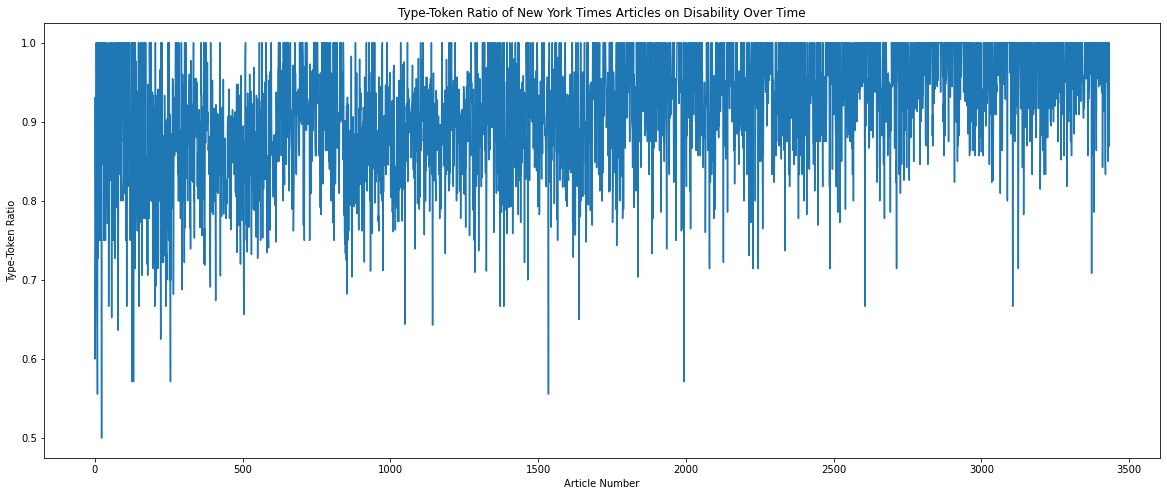

In [ ]:
# Plot type-token ratios
df_ttr["cleaned"].apply(type_token_ratio).plot(figsize=(20, 8))
plt.title("Type-Token Ratio of New York Times Articles on Disability Over Time")
plt.xlabel("Article Number")
plt.ylabel("Type-Token Ratio");

Type-token ratios divide the number of unique tokens by the total number of tokens in a text. They are commonly used to measure linguistic diversity. The above graph of type-token ratios across articles shows an upward slant, indicating that there has been an increase in this diversity over time.

## Individual Word Frequencies

In [ ]:
# Clean data for this task
def clean_wf(text):
  text = "".join(ch for ch in text if ch.isalnum() or ch == " ").lower()
  return [w for w in nltk.word_tokenize(text) if not w in stop_words]

In [ ]:
# Get a list of all words in this 
all_words = set(clean_wf(" ".join(all_data)))

In [ ]:
# Calculate the frequency of a given word in a given document
def get_freq(word, doc):
  return doc.count(word) / len(doc)

In [ ]:
# Create dataframe of frequencies of each word in each time interval
freq = pd.DataFrame(index=all_words)
for bin, texts_wf in data_bins.items():
  joined_texts = clean_wf(" ".join(texts_wf))
  freq[bin] = [get_freq(word, joined_texts) for word in all_words]
# Calculate the largest difference for one word between frequencies in different time intervals
freq["diff"] = freq.apply(lambda x: max(x) - min(x), axis=1)
freq.head()

,1860-1880,1880-1900,1900-1920,1920-1940,1940-1960,1960-1980,1980-2000,2000-2020,diff
subjective,0.0,0.0,0.0,0.0,0.0,0.0,0.000020,0.000000,0.000020
saramess,0.0,0.0,0.0,0.0,0.0,0.0,0.000020,0.000000,0.000020
soar,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000023,0.000023
imaginary,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000023,0.000023
gallery,0.0,0.0,0.0,0.0,0.0,0.0,0.000079,0.000047,0.000079


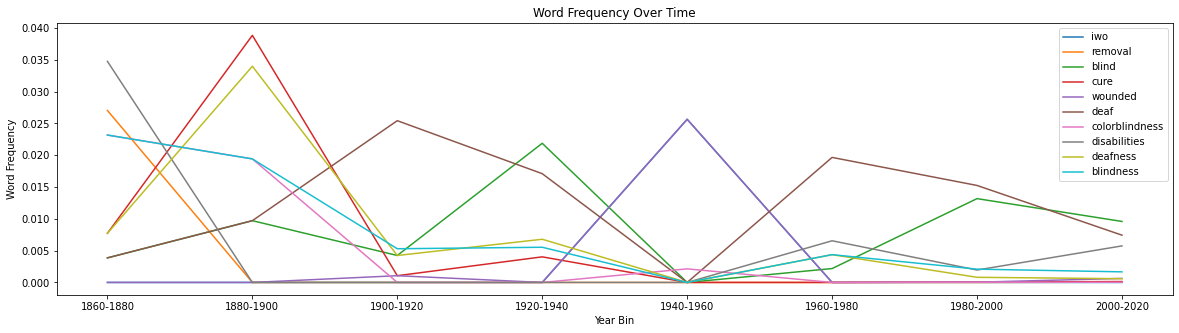

In [ ]:
# Plot frequencies of words with a change of over 0.02
freq[freq["diff"] > 0.02].iloc[:, :-1].transpose().plot(figsize=(20, 5))
plt.title("Word Frequency Over Time")
plt.xlabel("Year Bin")
plt.ylabel("Word Frequency")
plt.legend();

This graph illustrates the frequencies of words that have a maximum frequency change over 2% across bins.

Some notable themes emerge: "removal" peaks in the mid-1800s and drops suddenly, suggesting that calls to eliminate disability altogether disappeared. As seen previously, the usage of terms such as "deafness" and "blindness" taper off with a rise in "disabilities," illustrating how language has evolved in recent decades. In 1940-1960, the term "wounded" rises in popularity, likely as an effect of World War II disabling many American soldiers. Finally, in 1880-1900, "cure" and "deafness" are similarly high-frequency, mirroring the rise of oralism as a way to "fix" Deaf and hard-of-hearing people.

# Conclusion

This has highlighted a number of themes in how disability has discussed by the *New York Times* over time and highlighted areas for further research:

First, there appears to have been a shift from legislative elimination of disability to medical cures. Second, educating children with disabilities seems to have become a popular area for discourse in recent years. Third, language related to disability has transitioned from focusing on specific disabilities, such as Deafness or blindness, to discuss disability as a phenomenon more generally. Finally, the amount and diversity of disability-related articles appears to have increased significantly over time.

The analysis here could be expanded upon in many ways. Ideally, working with the actual text of the articles, rather than the headline and the abstract, would allow for more in-depth results due to larger corpora. It could also be improved by investigating the *New York Times*'s methods for labeling and archiving data to determine if any findings are spurious. Finally, a comparison of trends found in this subset of articles to those found in all *New York Times* articles would provide a clearer perspective into which patterns are specific to disability-related coverage.